# Quantum Algorithm Project: Quantum Machine Learning
### Syed Bilal Hyder - 22100181

In [ ]:
import numpy as np

from qiskit import IBMQ
IBMQ.load_account()

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import *
from qiskit import Aer
from qiskit import execute
from qiskit.visualization import circuit_drawer

from pylatexenc import *

from matplotlib import *
from matplotlib import pyplot as plt

For this project I will mainly be using *qiskit_machine_learning* library. This library contains some sample datasets that are widely used for quantum machine learning projects. Here I am using *digits* dataset that contains handwritten samples for **0** and **1** encoded as *8x8* Matrices. Each element of these matrices is a digit between 0 (representing white) and 16 (representing black).

In [ ]:
# Importing only 2 classes of data i.e. 0 and 1
digits = datasets.load_digits(n_class = 2)

Here I am splitting data into test and train portions, reducing its dimensionality, scaling it in range -1 to 1, and sampling 200 train, and 40 test samples. All of this was previosly done by the builtin function *digits* but its data output was difficult to precess for our requirement.

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(digits.data, digits.target, train_size = 0.8, test_size = 0.2)

# Reducing dimentions to the number of qubits we have to use
n_qubits = 5
pca = PCA(n_components = n_qubits).fit(train_data)
train_data = pca.transform(train_data)
test_data = pca.transform(test_data)

# Normalizing data
normalize = StandardScaler().fit(train_data)
train_data = normalize.transform(train_data)
test_data = normalize.transform(test_data)

# Scaling data
total_data = np.append(train_data, test_data, axis = 0)
scale = MinMaxScaler((-1,1)).fit(total_data)
train_data = scale.transform(train_data)
test_data = scale.transform(test_data)

# Taking samples
train_data = train_data[:200]
train_label = train_label[:200]
test_data = test_data[:40]
test_label = test_label[:40]


## Making feature maps to encode classical data into quantum form.
The problem of converting classical data into something that can be operated on by quantum computers, we use variational/parameterised circuits called feature maps.

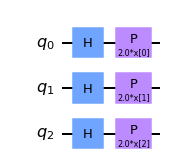

In [ ]:
# This is an example of a linear feature map. There is no entanglement what so ever in this circuit. Hence, there is essentially
# no chance of obtaining a quantum advantage out of this feature map.

map_z = ZFeatureMap(feature_dimension = 3, reps = 1)
map_z.decompose().draw('mpl')

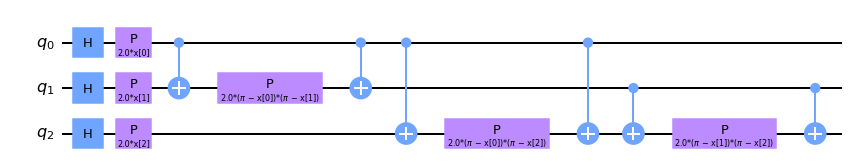

In [ ]:
# A better version of the previos feature map where the channels are linearly entangled.

map_zz = ZZFeatureMap(feature_dimension = 3, reps = 1)
map_zz.decompose().draw('mpl')

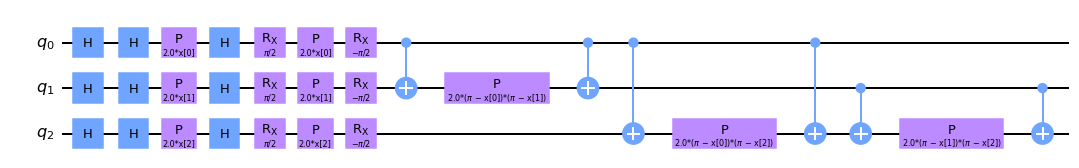

In [ ]:
# An available feature map that uses Pauli matrices.

pauli_map = PauliFeatureMap(feature_dimension = 3, reps = 1, paulis = ['X', 'Y', 'ZZ'])
pauli_map.decompose().draw('mpl')

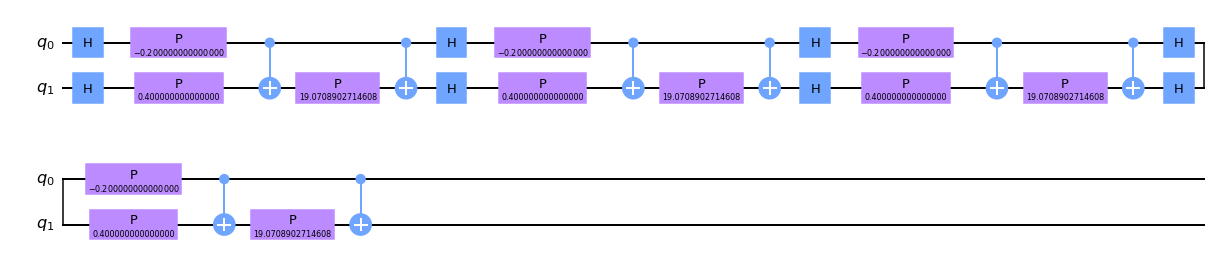

In [ ]:
# A small example of a small vector being encoded into quantum data by one of the feature maps.

pt_x = [-0.1, 0.2]
encode_map = ZZFeatureMap(feature_dimension = 2, reps = 4)
encode_x = encode_map.bind_parameters(pt_x)
encode_x.decompose().draw('mpl')

[ 0.48604637 -0.64819077 -0.25398979 -0.63343896  0.05700825]


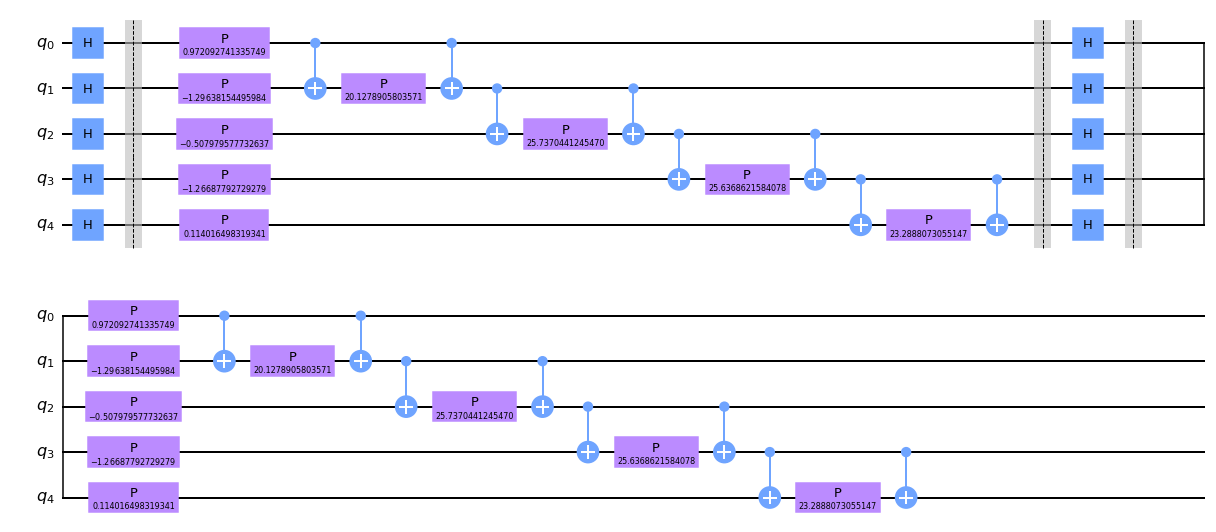

In [ ]:
# Creating a Feature Map for a sample from our data that has 4 dimensions now.
sample = train_data[0]
print(sample)
zz_map = ZZFeatureMap(feature_dimension = 5, reps = 2, entanglement = 'linear', insert_barriers = True)
zz_circuit = zz_map.bind_parameters(sample)
zz_circuit.decompose().draw('mpl')

## Setting up quantum kernels which will let us classify the data

In [ ]:
print('Vectors to demonstrate the process of making a kernel:\n',train_data[0:2])

Vectors to demonstrate the process of making a kernel:
 [[ 0.48604637 -0.64819077 -0.25398979 -0.63343896  0.05700825]
 [-0.81528884 -0.25736284 -0.68639246 -0.41063955  0.25589617]]


Circuit implementation


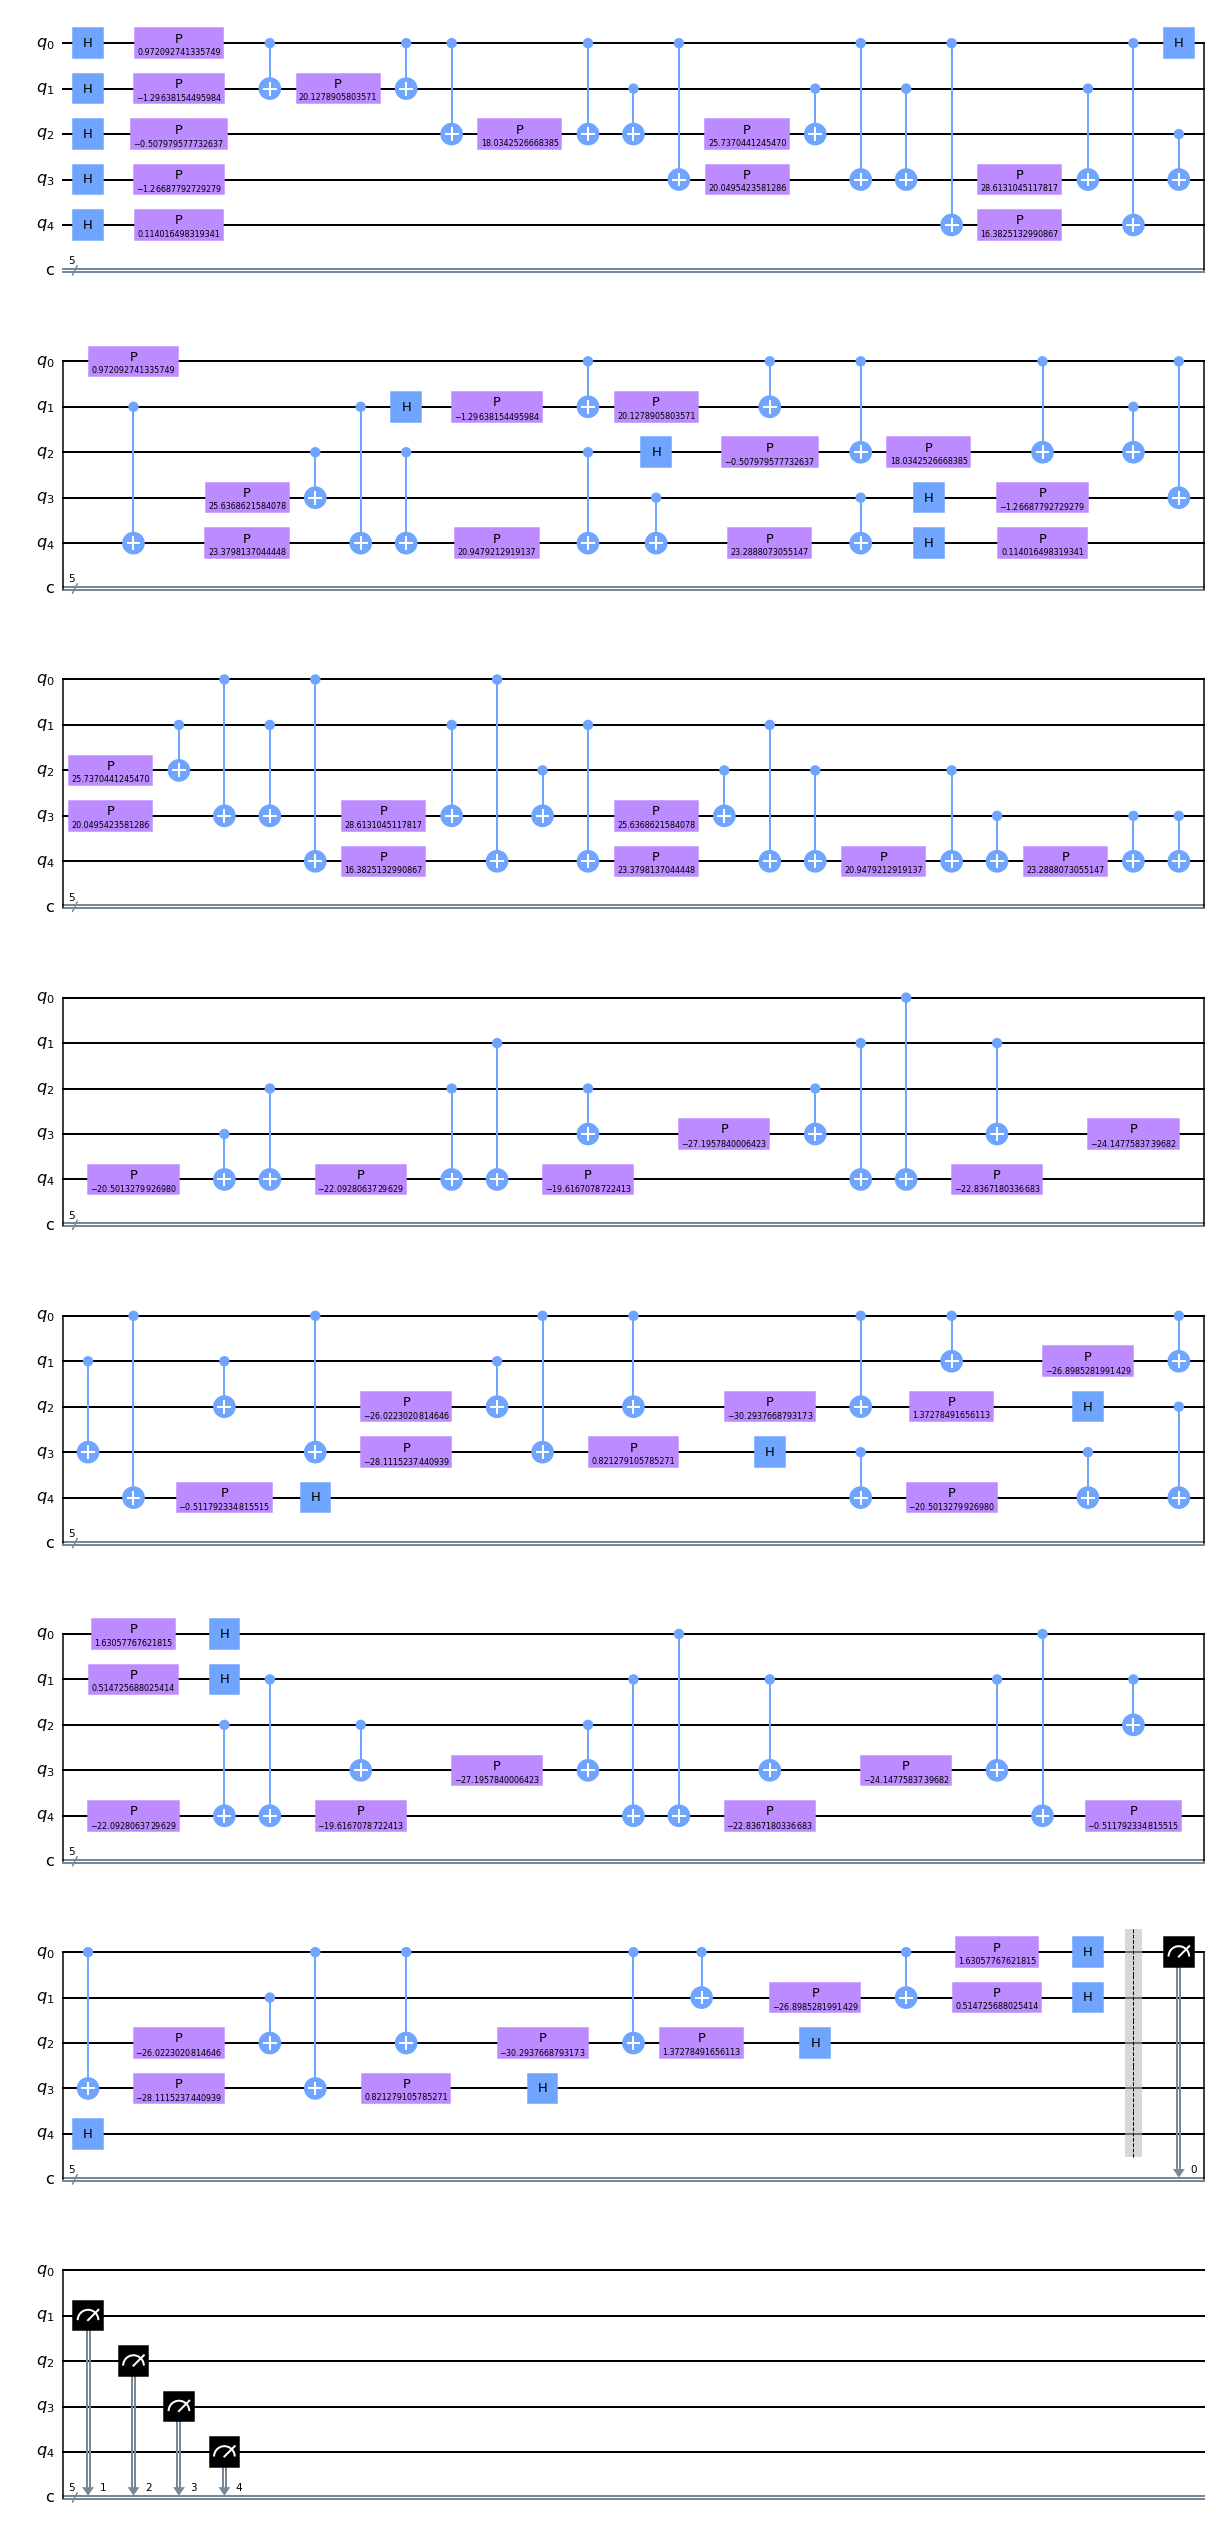

In [ ]:
# First, we will calculate the transition amplitude between the first two 1x4 vectors in the training data
zz_map = ZZFeatureMap(feature_dimension=5, reps=2)
zzkernel = QuantumKernel(feature_map = zz_map, quantum_instance = Aer.get_backend('statevector_simulator'))

zzcircuit = zzkernel.construct_circuit(train_data[0], train_data[1])
print('Circuit implementation')

zzcircuit.decompose().decompose().draw('mpl')

In [ ]:
# Running the circuit on a simulator.
provider = IBMQ.get_provider(hub='ibm-q')
q_comp = provider.get_backend('ibmq_manila')

job = execute(zzcircuit, q_comp, shots = 8000, seed_simulator = 1000, seed_transpiler = 1000)
counts = job.result().get_counts(zzcircuit)

Transition Amplitude is defined as the proportion of counts in the zero state. These transition elements are to be calculated for every training example with the other. This makes our training kernel matrix. Doing this between the training and test data gives us the testing kernel matrix.

In [ ]:
transition_amplitude = counts['00000']/sum(counts.values())
print("Transition amplitude for our first two vectors:", transition_amplitude)

Transition amplitude for our first two vectors: 0.031625


In [ ]:
train_ker_matrix = zzkernel.evaluate(x_vec = train_data)
test_ker_matrix = zzkernel.evaluate(x_vec = test_data, y_vec = train_data)

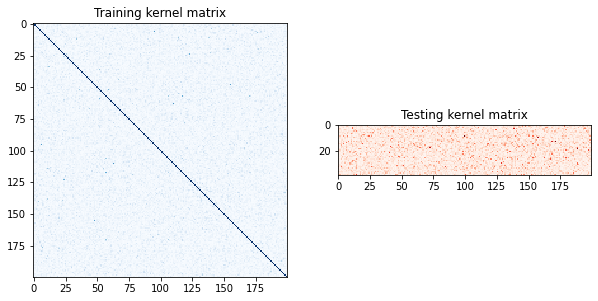

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(train_ker_matrix), interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(test_ker_matrix), interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("Testing kernel matrix")
plt.show()

These were all of the quantum computations that we had to do for quantum machine learning. Once we have obtained these kernel matriceas, we can use them in classical support vector machines (SVMs), and use them to classify data. For this purpose, we will use **scikit learn**'s **svc** library. This library lets us define custom kernels using kernel matrices that we have obtained in the previous steps. For project completion, I could use the SVC library and compute the accuracy score of our model and compare it with the available classical models.

In [ ]:
from sklearn.svm import SVC

In [ ]:
zz_svc = SVC(kernel = 'precomputed')
zz_svc.fit(train_ker_matrix, train_label)
zz_score = zz_svc.score(test_ker_matrix, test_label)
print("Classification score:", zz_score)

Classification score: 0.725


Made some cahnges to the code. Previosly, data was being imported for all 10 digits. That was taking a lot of time to process **0** and **1** out of it, so I imported the data in a different way, and pre-processed for use in our algirithm.

The circuit has now expanded to 5 qubits, so the feature space had to be coverted to 5 features as well. The number of fuatures must equal the number of qubits used. Max available qubits on IBMQ were 5, so I chose it for this project.

Doubled the size of train and test data for a better evaluation of our model.

Results for our data give us 0.725 accuracy when run over a quantum computer, which is quite a decent result provided the simulator also generated an accuracy of 0.75.